In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer




In [9]:
import os
os.getcwd()


'c:\\Users\\darry'

In [14]:
df = pd.read_csv(r"C:\Users\darry\Data Analysis ML Project Portfolio\No-Show Rate Proj 1\Data\noshows.csv")
df.head(), df.shape

(      PatientId  AppointmentID Gender          ScheduledDay  \
 0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
 1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
 2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
 3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
 4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
 
          AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
 0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
 1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
 2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
 3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
 4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   
 
    Diabetes  Alcoholism  Handcap  SMS_received No-show  
 0         0           0        0             0      No  
 1         0          

In [15]:
df.info

<bound method DataFrame.info of            PatientId  AppointmentID Gender          ScheduledDay  \
0       2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1       5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2       4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3       8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4       8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
...              ...            ...    ...                   ...   
110522  2.572134e+12        5651768      F  2016-05-03T09:15:35Z   
110523  3.596266e+12        5650093      F  2016-05-03T07:27:33Z   
110524  1.557663e+13        5630692      F  2016-04-27T16:03:52Z   
110525  9.213493e+13        5630323      F  2016-04-27T15:09:23Z   
110526  3.775115e+14        5629448      F  2016-04-27T13:30:56Z   

              AppointmentDay  Age      Neighbourhood  Scholarship  \
0       2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0   
1       2016-

In [ ]:
df.columns = [c.strip().replace("-", "_").replace(" ", "_") for c in df.columns]

#Outcome: 1 = no-show, 0 = show
df["no_show"] = (df["No_show"].str.lower() == "yes").astype(int)
df["no_show"].value_counts(normalize=True)


no_show
0    0.798067
1    0.201933
Name: proportion, dtype: float64

In [17]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


In [28]:
sms_table = (
    df.groupby("SMS_received")["no_show"]
      .agg(["mean", "count"])
      .rename(columns={"mean": "no_show_rate", "count": "num_appointments"})
)

sms_table


,no_show_rate,num_appointments
SMS_received,,
0,0.167033,75045
1,0.275745,35482


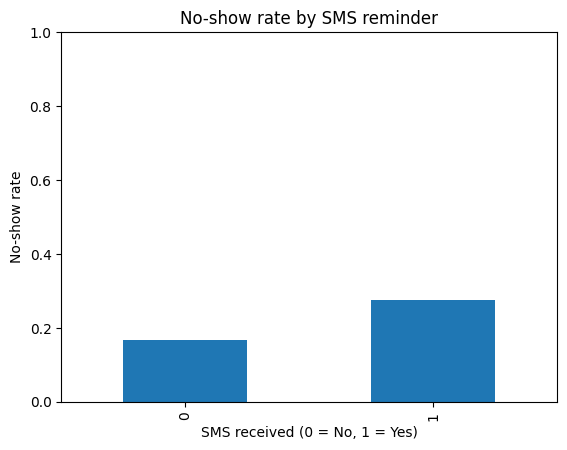

In [29]:
sms_table["no_show_rate"].plot(kind="bar")
plt.title("No-show rate by SMS reminder")
plt.ylabel("No-show rate")
plt.xlabel("SMS received (0 = No, 1 = Yes)")
plt.ylim(0, 1)
plt.show()


In [31]:
# Odds of no-show given SMS
odds_sms = ct.loc[1,1] / ct.loc[1,0]

# Odds of no-show without SMS
odds_no_sms = ct.loc[0,1] / ct.loc[0,0]

odds_ratio = odds_sms / odds_no_sms
odds_ratio


np.float64(1.8986384857553336)

In [ ]:
# Convert date columns to datetime
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"])
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"])

df["lead_days"] = (df["AppointmentDay"] - df["ScheduledDay"]).dt.days
df["lead_days"] = df["lead_days"].clip(lower=0)
df["appt_weekday"] = df["AppointmentDay"].dt.dayofweek

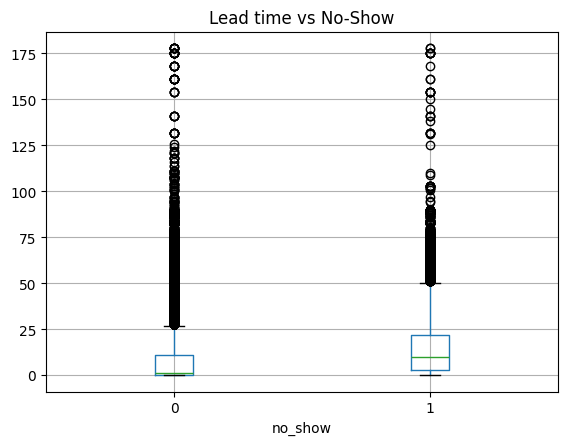

In [24]:
df.groupby("no_show")["lead_days"].describe()
df.boxplot(column="lead_days", by="no_show")
plt.title("Lead time vs No-Show")
plt.suptitle("")
plt.show()


In [ ]:
# Separate features (X) from the outcome (y)
drop_cols = [c for c in ["PatientId", "AppointmentID", "No_show", "ScheduledDay", "AppointmentDay"] if c in df.columns]
X = df.drop(columns=drop_cols + ["no_show"])
y = df["no_show"]


              precision    recall  f1-score   support

           0       0.80      0.99      0.89     17642
           1       0.38      0.02      0.03      4464

    accuracy                           0.80     22106
   macro avg       0.59      0.50      0.46     22106
weighted avg       0.72      0.80      0.71     22106

ROC AUC: 0.6604501799327037


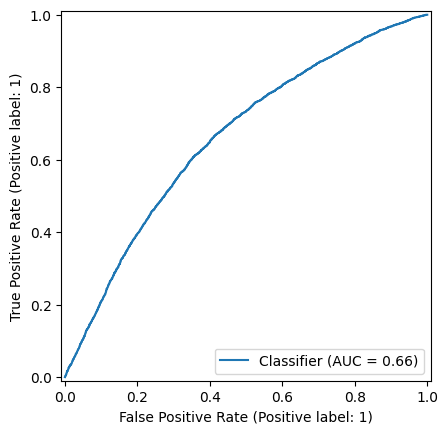

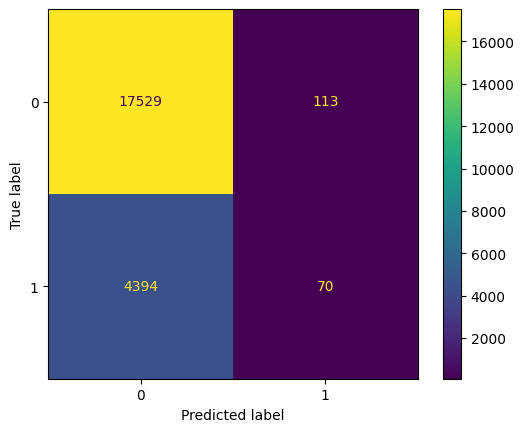

In [ ]:
# Identify categorical and numerical columns 
categorical_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()
numeric_cols = [c for c in X.columns if c not in cat_cols]

#Pipelines for preprocessing data for modeling
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols),
    ]
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, proba))

RocCurveDisplay.from_predictions(y_test, proba)
plt.show()
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()


In [27]:
ohe = clf.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.r_[num_cols, cat_feature_names]
coefs = clf.named_steps["model"].coef_[0]

imp = pd.Series(coefs, index=feature_names).sort_values()
imp.tail(15)  # strongest positive drivers of no-show


Neighbourhood_SANTA CECÍLIA          0.166637
Neighbourhood_DO MOSCOSO             0.168965
Neighbourhood_SÃO JOSÉ               0.184626
Neighbourhood_ILHA DAS CAIEIRAS      0.189653
Neighbourhood_ARIOVALDO FAVALESSA    0.224954
Neighbourhood_SÃO PEDRO              0.228962
Neighbourhood_ANDORINHAS             0.230279
Neighbourhood_BENTO FERREIRA         0.236927
Neighbourhood_CARATOÍRA              0.249512
Neighbourhood_ILHA DO PRÍNCIPE       0.290219
Neighbourhood_ITARARÉ                0.316403
Neighbourhood_PARQUE MOSCOSO         0.334922
lead_days                            0.365579
Neighbourhood_SANTA CLARA            0.390031
Neighbourhood_SANTOS DUMONT          0.443058
dtype: float64

In [32]:
print(cat_cols)

['Gender', 'Neighbourhood']


In [33]:
print(num_cols)

['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'lead_days', 'appt_dow']
